In [1]:
from pyspark.sql import SparkSession
import os

In [2]:
spark = (
        SparkSession.builder
        .appName("taxi-analysis")
        .config("spark.driver.bindAddress", "127.0.0.1")
        .config("spark.driver.host", "127.0.0.1")
        .config("spark.driver.memory", "4g")
        .config("spark.executor.memory", "4g")
        .getOrCreate()
    )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/30 19:08:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data Ingestion
---

In [3]:
data_dir = f'{os.getcwd()}/missions/W4/M2/data'
trips_file = 'yellow_tripdata_2023-01.parquet'

if not os.path.exists(f'{data_dir}/{trips_file}'):
    ! wget -P "{data_dir}" "https://d37ci6vzurychx.cloudfront.net/trip-data/{trips_file}"

trips_df = spark.read.parquet(f'file:///{data_dir}/{trips_file}', header = True)

# EDA
---

In [4]:
trips_df.printSchema()
trips_df.show(5)

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+----

In [5]:
print(f'Row count: {trips_df.count()}')
print(f'Colunm count: {len(trips_df.columns)}')

Row count: 3066766
Colunm count: 19


In [7]:
# summary = trips_df.summary()
# summary.show(10)

# Data Cleaning and Transformation
---

In [6]:
from pyspark.sql.functions import count, when, isnull, col, to_timestamp
from functools import reduce

def clean_null(df):
    print('결측값 필터링 ...')

    trips_df.select([count(when(col(c).isNull(), c)).alias(c) for c in trips_df.columns]).show()

    df = df.dropna()
    return df

def clean_outlier(df):
    print('이상치 필터링 ...')

    df.select(
        count(when(col("passenger_count") < 1, "passenger_count")).alias("negative_trip_duration"),
        count(when(col("trip_distance") <= 0, "trip_distance")).alias("negative_trip_distance"),
        count(when(col("fare_amount") <= 0, "fare_amount")).alias("negative_fare_amount"),
        count(when(col("passenger_count") < 1, "passenger_count")).alias("invalid_passenger_count")
    ).show()

    df =  df.filter(
                (col("tpep_dropoff_datetime") >= col("tpep_pickup_datetime")) &
                (col("trip_distance") > 0) & 
                (col("fare_amount") > 0) & 
                (col("passenger_count") >= 1)
            )
    return df

def transform_timestamp(df):
    print('Timestamp 정규화 ...')

    df.select('tpep_pickup_datetime').show(5)
    df.select('tpep_dropoff_datetime').show(5)

    df = df.withColumn("tpep_pickup_datetime", to_timestamp(col("tpep_pickup_datetime")))
    df = df.withColumn("tpep_dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime")))

    df.select('tpep_pickup_datetime').show(5)
    df.select('tpep_dropoff_datetime').show(5)

    return df

trips_df = clean_null(trips_df)
trips_df = clean_outlier(trips_df)
trips_df = transform_timestamp(trips_df)

결측값 필터링 ...


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|          71743|            0|     71743|             71743|           0|           0|           0|          0|    0|      0|         

# Metrics Calculation
---

In [7]:
from pyspark.sql.functions import col, unix_timestamp, avg, round

def get_trip_duration_unix(df):
    df = df.withColumn("trip_duration", (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))))
    df.select('trip_duration').show(5) # by seconds
    return df

def calc_moving_metrics_avg(df):
    metrics_df = df.select(
    round(avg("trip_duration"), 2).alias("average_trip_duration_minutes"),
    round(avg("trip_distance"), 2).alias("average_trip_distance_km")
)

    duration_metrics_row = metrics_df.collect()[0]
    avg_duration = duration_metrics_row["average_trip_duration_minutes"]
    avg_distance = duration_metrics_row["average_trip_distance_km"]

    print(f"Average Trip Duration per minute: {(avg_duration / 60):.2f} minutes")
    print(f"Average Trip Distance: {avg_distance:.2f} km")

trips_df = get_trip_duration_unix(trips_df)
calc_moving_metrics_avg(trips_df)

+-------------+
|trip_duration|
+-------------+
|          506|
|          379|
|          765|
|          650|
|          738|
+-------------+
only showing top 5 rows



Average Trip Duration per minute: 15.78 minutes
Average Trip Distance: 3.47 km


# Peak Hours Analysis
---

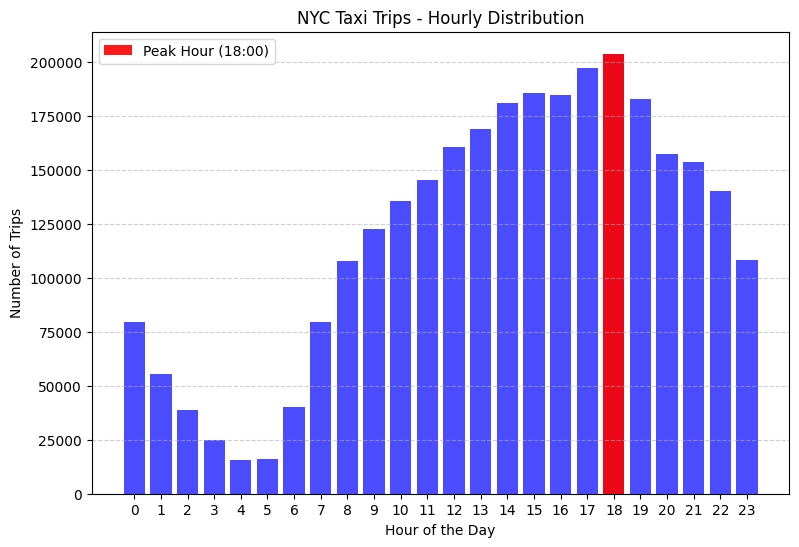

In [8]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import hour, count, col, max

def get_pickup_hours(df):
      df = df.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))\
                        .groupBy("pickup_hour")\
                        .agg(count("*").alias("trip_count"))\
                        .orderBy("pickup_hour")
      return df

def get_peek_hour(pandas_df):
    max_trip_count = pandas_df['trip_count'].max()
    peek_hour = pandas_df[pandas_df['trip_count'] == max_trip_count]['pickup_hour'].iloc[0]
    return (peek_hour, max_trip_count)

def visualize_pickup_hours(pandas_df):
    plt.figure(figsize=(9, 6))
    plt.bar(pandas_df["pickup_hour"], pandas_df["trip_count"], color="blue", alpha=0.7)

    peek_hour, max_trip_count = get_peek_hour(pandas_df)
    for hour in pandas_df['pickup_hour']:
            if hour == peek_hour:
                plt.bar(hour, max_trip_count, color="red", alpha=0.9, label=f"Peak Hour ({hour}:00)")

    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Trips")
    plt.title("NYC Taxi Trips - Hourly Distribution")
    plt.xticks(range(24))
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)


trips_pickup_hours_df = get_pickup_hours(trips_df)
trips_pd_df = trips_pickup_hours_df.toPandas()
visualize_pickup_hours(trips_pd_df)

# Weather Condition Analysis
---

# Output
---

In [9]:
output_path = f'{os.getcwd()}/missions/W4/M2/data/output'
analysis_file = f'analysis-{trips_file}'
if not os.path.exists(output_path):
    os.makedirs(output_path)

trips_df.write.mode("overwrite").parquet(f"file://{output_path}/{analysis_file}")